In [671]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from binance import Client
from finta import TA
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [672]:
# Instantiate Binance client
client = Client()
# Set the fiat currency to use
fiat = 'USDT'

In [673]:
def get_historical_data(currency):
    klines = client.get_historical_klines(
        currency + fiat,
        Client.KLINE_INTERVAL_4HOUR,
        "5 year ago UTC"
    )
    # klines columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
    cols_ohlcv = ('open', 'high', 'low', 'close', 'volume')
    df = pd.DataFrame((x[:6] for x in klines), columns=['timestamp', *cols_ohlcv])
    df[[*cols_ohlcv]] = df[[*cols_ohlcv]].astype(float)
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df.drop(columns='timestamp', inplace=True)

    return df

df = get_historical_data('ETH')
df.head()



,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,301.13,307.96,298.00,307.96,1561.95305
2017-08-17 08:00:00,307.95,312.00,307.00,308.95,1177.71088
2017-08-17 12:00:00,308.95,310.51,303.56,307.06,1882.05267
2017-08-17 16:00:00,307.74,312.18,298.21,301.60,1208.05192
2017-08-17 20:00:00,301.60,310.85,299.01,302.00,1200.94182


## Step 2: Generate trading signals using short- and long-window SMA values. 

### Trading indicators

In [ ]:
### What indicators

In [674]:

#indicators

#EMA
   # Set the short window and long windows
EMA_short_window = 9
EMA_long_window = 50
    # Add the EMA technical indicators for the short and long windows
df["EMAShort"] = TA.SMA(df, EMA_short_window)
df["EMALong"] = TA.SMA(df, EMA_long_window)

#RSI - if above 70 and below 30
df["RSI"] = TA.RSI(df, 14)

#Bollinger Bands - if price touch upper and lower bands
BBands =  TA.BBANDS(df, 14)

#MACD - if signal crosses MACD
MACD =  TA.MACD(df)
MACD.columns = ["MACD","MACD_signal"]

#DMI - If
DMI =  TA.DMI(df, period = 14)

#VWAP
df["VWAP"] =  TA.VWAP(df)

df = pd.concat([df, BBands, MACD, DMI], axis=1 )
    
df



,open,high,low,close,volume,EMAShort,EMALong,RSI,VWAP,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,MACD_signal,DI+,DI-
date,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,301.13,307.96,298.00,307.96,1561.95305,NaN,NaN,NaN,304.640000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2017-08-17 08:00:00,307.95,312.00,307.00,308.95,1177.71088,NaN,NaN,100.000000,306.650378,NaN,NaN,NaN,0.022212,0.012340,NaN,NaN
2017-08-17 12:00:00,308.95,310.51,303.56,307.06,1882.05267,NaN,NaN,32.723112,306.810397,NaN,NaN,NaN,-0.030307,-0.005138,NaN,NaN
2017-08-17 16:00:00,307.74,312.18,298.21,301.60,1208.05192,NaN,NaN,10.579531,306.227333,NaN,NaN,NaN,-0.250582,-0.088283,NaN,NaN
2017-08-17 20:00:00,301.60,310.85,299.01,302.00,1200.94182,NaN,NaN,15.111572,305.838902,NaN,NaN,NaN,-0.349084,-0.165865,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06 12:00:00,2608.25,2648.78,2605.24,2626.84,56816.09420,2642.700000,2780.2104,37.422531,1131.609637,2715.504853,2647.510714,2579.516575,-52.330886,-48.117052,9.708863,21.144779
2022-03-06 16:00:00,2626.83,2654.79,2604.00,2607.03,50896.19290,2639.242222,2777.3214,35.391736,1131.693798,2680.417698,2637.699286,2594.980874,-52.600432,-49.013728,9.875038,19.634437
2022-03-06 20:00:00,2607.03,2644.45,2535.00,2551.29,87316.89080,2628.475556,2772.6456,30.393856,1131.833798,2687.811585,2629.097143,2570.382701,-56.658675,-50.542717,9.169678,27.909397


### Add Daily Returns

In [675]:
df["Actual Returns"] = df["close"].pct_change()
df = df.dropna()

### Trading Signals and their conditions

In [676]:

def EMA_signal(i):
            #if short crosses over long - buy
            if df["EMAShort"][i] <= df["EMALong"][i]:
                signal_list.append(1.0)
            #if long crosses over short - sell
            elif df["EMALong"][i] < df["EMAShort"][i]:
                signal_list.append(-1.0)
            else:
                signal_list.append(0.0)
                
def RSI_signal(i):
            if df["RSI"][i] >= 70:
                signal_list.append(-1.0)
            elif df["RSI"][i] <= 30:
                signal_list.append(1.0)
            else:
                signal_list.append(0.0)
                
                
def BB_signal(i):
            if df["BB_UPPER"][i] >= df["close"][i]:
                signal_list.append(1.0)
            elif df["BB_LOWER"][i] <= df["close"][i]:
                signal_list.append(-1.0)
            else:
                signal_list.append(0.0)
        
def MACD_signal(i):
            if df["MACD_signal"][i] > df["MACD"][i]:
                signal_list.append(1.0)
            elif df["MACD_signal"][i] < df["MACD"][i]:
                signal_list.append(-1.0)
            else:
                signal_list.append(0.0)
                
                
def DMI_signal(i):
            if df["DI+"][i] >= df["DI-"][i]:
                signal_list.append(1.0)
            elif df["DI+"][i] < df["DI-"][i]:
                 signal_list.append(-1.0)
            else:
                signal_list.append(0.0)
                    
def VWAP_signal(i):
            if df["VWAP"][i] >= df["close"][i]:
                signal_list.append(1.0)
            elif df["VWAP"][i] < df["close"][i]:
                signal_list.append(-1.0)
            else:
                signal_list.append(0.0)


In [688]:
#Amount to invest each change
account = 10000 #account balance
amount = 1000 #amount invested on buy
trade_limit = 2 #no. of trades in a row

#set signsl column to df
df['Signal'] = 0.0
buy_price = [0.0]
sell_price = [0.0]
buy_counter = 0
sell_counter = trade_limit

#for each row in df
for i in df.index:
    signal_list = []
    
    '''
    if ((df["EMAShort"][i] < df["EMALong"][i]) | (df["RSI"][i] <= 30)) & (buy_counter != trade_limit) & (account > 0):
            df["Signal"][i] = 1.0
            buy_price.append(amount/df["close"][i])
            account -= amount
            buy_counter += 1
            sell_counter = 0
    if (df["EMAShort"][i] >= df["EMALong"][i]) &  (df["RSI"][i] >= 70) & (sell_counter != trade_limit):
            df["Signal"][i] = -1.0
            sell_price.append(amount/df["close"][i])
            sell_counter += 1
            account += (amount * (amount/df["close"][i]))
            buy_counter = 0
            '''
    
           #selected indicators
    EMA_signal(i)
    RSI_signal(i)
    #BB_signal(i)
    #MACD_signal(i)
    #DMI_signal(i)
    #VWAP_signal(i)

    
 
    ###If buy price decreases by 0.1 1 stop loss
    if (np.mean(signal_list) == 1.0) & (buy_counter != trade_limit):
            df["Signal"][i] = 1.0
            buy_price.append(amount/df["close"][i])
            account -= amount
            buy_counter += 1
            sell_counter = 0
    elif (np.mean(signal_list) == -1.0) & (sell_counter != trade_limit):
            df["Signal"][i] = -1.0
            sell_price.append(amount/df["close"][i])
            sell_counter += 1
            account += (amount * (amount/df["close"][i]))
            buy_counter = 0
    else:
        df["Signal"][i] = 0.0
 

In [689]:
profit_loss = pd.DataFrame(
    {'Buy': buy_price
    })

profit_loss['Sell'] = pd.Series(sell_price)
profit_loss["Returns"] = profit_loss["Sell"] - profit_loss["Buy"] 
profit_loss = profit_loss.dropna()


profit_loss["pchange"] = profit_loss["Returns"].pct_change()
profit_loss['Cumulative'] = profit_loss['Returns'].cumsum()
profit_loss['Cum_buy'] = profit_loss['Buy'].cumsum()
profit_loss['Cum_sell'] = profit_loss['Sell'].cumsum()

In [690]:
profit_loss.tail()

,Buy,Sell,Returns,pchange,Cumulative,Cum_buy,Cum_sell
55,0.232041,0.302123,0.070082,-20.096937,26.180543,186.338521,212.519064
56,0.231905,0.217843,-0.014062,-1.200657,26.166480,186.570426,212.736906
57,0.256838,0.216739,-0.040099,1.851497,26.126381,186.827263,212.953645
58,0.258641,0.337981,0.079339,-2.978591,26.205721,187.085905,213.291625
59,0.367284,0.333891,-0.033393,-1.420887,26.172328,187.453188,213.625516


<AxesSubplot:>

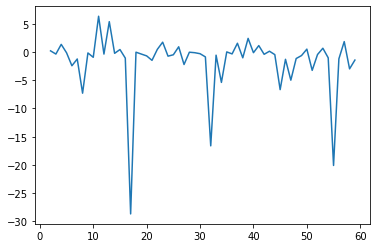

In [691]:
profit_loss["pchange"].plot()

<AxesSubplot:>

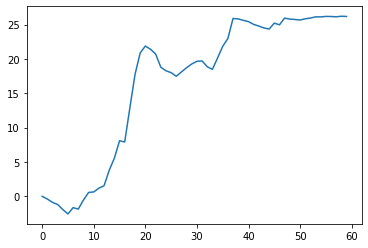

In [692]:
profit_loss['Cumulative'].plot()

In [693]:

EMA_plot = df[["EMAShort", "EMALong"]].hvplot(
    color = "orange",
    ylabel='Price in $',
    width=1000,
    height=400
)

RSI_plot = df[["RSI"]].hvplot(
    color = "orange",
    ylabel='Price in $',
    width=1000,
    height=400
)

BB_plot = df[["BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].hvplot(
    color = "purple",
    ylabel='Price in $',
    width=1000,
    height=400
)

MACD_plot = df[["MACD", "MACD_signal"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

DMI_plot = df[["DI+", "DI-"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

VWAP_plot = df[["VWAP"]].hvplot(
    color = "blue",
    ylabel='Price in $',
    width=1000,
    height=400
)


In [694]:
# Visualize entry position relative to close price
entry = df[df["Signal"] == 1.0]["close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

EMA_plot = df[["EMAShort", "EMALong"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = df[df["Signal"] == -1.0]["close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[["close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)
plot_list = [VWAP_plot, DMI_plot]

entry_exit_plot = security_close * entry * exit 

# Overlay plots
for i in plot_list:
    if i ==  DMI_plot:
        DMI_plot = i
    elif (i == RSI_plot):
        RSI_plot = i
    else:
        entry_exit_plot *= i
    
display(entry_exit_plot)
small_plot

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)
   .Curve.II         :Curve   [date]   (VWAP)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

### Step 3: Split the data into training and testing datasets.

In [695]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = df[df['Signal'] != 0]
X = X[["EMAShort", "EMALong", "RSI"]].shift().dropna()

# Review the DataFrame
X.head()

,EMAShort,EMALong,RSI
date,,,
2017-09-04 12:00:00,333.901111,358.8432,22.529331
2017-09-27 16:00:00,319.176667,356.7448,26.343539
2017-09-27 20:00:00,293.657778,282.0756,70.101189
2017-10-18 08:00:00,295.537778,282.4708,70.756543
2017-11-02 00:00:00,315.880000,321.4782,28.721618


In [696]:
# Create the target set selecting the Signal column and assiging it to y
y = df[df['Signal'] != 0]['Signal']

# Review the value counts
y.value_counts()


 1.0    60
-1.0    59
Name: Signal, dtype: int64

In [697]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2017-09-04 12:00:00


In [698]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2017-12-04 12:00:00


In [699]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,EMAShort,EMALong,RSI
date,,,
2017-09-04 12:00:00,333.901111,358.8432,22.529331
2017-09-27 16:00:00,319.176667,356.7448,26.343539
2017-09-27 20:00:00,293.657778,282.0756,70.101189
2017-10-18 08:00:00,295.537778,282.4708,70.756543
2017-11-02 00:00:00,315.880000,321.4782,28.721618


In [700]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=4):]
y_test = y.loc[training_end+DateOffset(hours=4):]

# Review the X_test DataFrame
X_train.head()

,EMAShort,EMALong,RSI
date,,,
2017-09-04 12:00:00,333.901111,358.8432,22.529331
2017-09-27 16:00:00,319.176667,356.7448,26.343539
2017-09-27 20:00:00,293.657778,282.0756,70.101189
2017-10-18 08:00:00,295.537778,282.4708,70.756543
2017-11-02 00:00:00,315.880000,321.4782,28.721618


In [701]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [702]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [703]:
# Use a classification report to evaluate the model using the predictions and testing data
# Print the classification report
predictions_report = classification_report(y_train, training_signal_predictions, digits=4)
print(predictions_report)


              precision    recall  f1-score   support

        -1.0     0.5714    1.0000    0.7273         4
         1.0     0.0000    0.0000    0.0000         3

    accuracy                         0.5714         7
   macro avg     0.2857    0.5000    0.3636         7
weighted avg     0.3265    0.5714    0.4156         7



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [704]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted"]
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-12-07 12:00:00,-1.0,-0.013411,0.013411
2017-12-12 00:00:00,-1.0,0.043267,-0.043267
2017-12-12 04:00:00,-1.0,-0.002129,0.002129
2018-01-16 16:00:00,-1.0,-0.085974,0.085974
2018-01-16 20:00:00,-1.0,-0.023151,0.023151


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-12-04 08:00:00,-1.0,-0.006973,0.006973
2022-02-04 16:00:00,-1.0,0.030284,-0.030284
2022-02-04 20:00:00,-1.0,0.012248,-0.012248
2022-02-19 08:00:00,-1.0,-0.031778,0.031778
2022-02-20 04:00:00,-1.0,-0.021728,0.021728


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='date'>

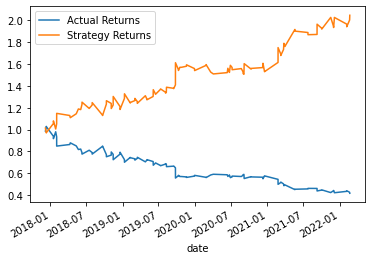

In [705]:
# Plot the actual returns versus the strategy returns
(1 +  predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [376]:
# Import a new classifier from SKLearn
from xgboost import XGBClassifier
# Initiate the model instance
xgbc_model = XGBClassifier()


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [377]:
# Fit the model using the training data
model = xgbc_model.fit(X_train_scaled, y_train)  

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)   

# Review the model's predicted values
pred[0:10]

[13:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [378]:
# Use a classification report to evaluate the model using the predictions and testing data
report = classification_report(y_test, pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

        -1.0       0.51      1.00      0.68        53
         1.0       0.00      0.00      0.00        51

    accuracy                           0.51       104
   macro avg       0.25      0.50      0.34       104
weighted avg       0.26      0.51      0.34       104



C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [379]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted"]
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-12-07 12:00:00,-1.0,-0.013411,0.013411
2017-12-12 00:00:00,-1.0,0.043267,-0.043267
2017-12-12 04:00:00,-1.0,-0.002129,0.002129
2018-01-17 04:00:00,-1.0,0.029841,-0.029841
2018-01-17 08:00:00,-1.0,-0.110702,0.110702


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-12-28 20:00:00,-1.0,-0.003994,0.003994
2022-02-04 16:00:00,-1.0,0.030284,-0.030284
2022-02-04 20:00:00,-1.0,0.012248,-0.012248
2022-02-19 08:00:00,-1.0,-0.031778,0.031778
2022-02-20 04:00:00,-1.0,-0.021728,0.021728


<AxesSubplot:xlabel='date'>

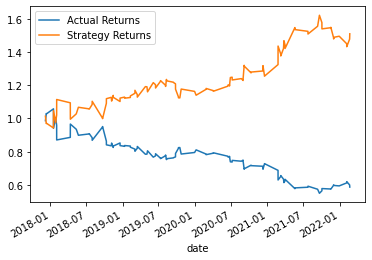

In [380]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

# Try SVM Model

## Step 1

In [381]:
# Create the classifier model
svm_model = svm.SVC()

## Step 2

In [382]:

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1.])

## Step 3

In [383]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display the report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.57      1.00      0.73         4
         1.0       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\colle\anaconda3\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [384]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted"]
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-12-07 12:00:00,-1.0,-0.013411,0.013411
2017-12-12 00:00:00,-1.0,0.043267,-0.043267
2017-12-12 04:00:00,-1.0,-0.002129,0.002129
2018-01-17 04:00:00,-1.0,0.029841,-0.029841
2018-01-17 08:00:00,-1.0,-0.110702,0.110702


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-12-28 20:00:00,-1.0,-0.003994,0.003994
2022-02-04 16:00:00,-1.0,0.030284,-0.030284
2022-02-04 20:00:00,-1.0,0.012248,-0.012248
2022-02-19 08:00:00,-1.0,-0.031778,0.031778
2022-02-20 04:00:00,-1.0,-0.021728,0.021728


<AxesSubplot:xlabel='date'>

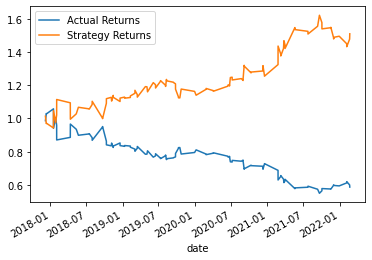

In [385]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()